# Transforms used in compression

Notebook with some transforms that can be part of a compression method.

In [1]:
% matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def plot_image(im, fig_num=0, fname=None):
    """Plot grayscale image"""
    plt.figure(fig_num)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    
    if fname is not None:
        cv2.imwrite(fname, im)
    fig_num += 1
    return fig_num

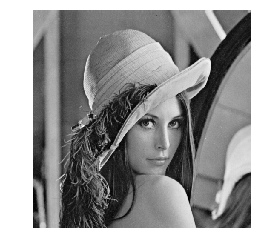

In [3]:
im = cv2.imread('assets/images/lena.png', cv2.IMREAD_GRAYSCALE)

fig_num = plot_image(im)

## Difference transform

In [4]:
def forward_difference(im):
    """Forward difference transform
    
    Args:
        im: 2D numpy array of uint8.
        
    Returns:
        diff_im: 2D numpy array of uint8. Difference transform image of im,
                 with 128 added to avoid zero values.
    
    """
    m, n = im.shape
    im = im.astype(int)
    diff_im = np.zeros((m, n), dtype=int)
    for i in range(m):
        orig_row = im[i, :]
        diff_row = np.zeros(n, dtype=int)
        diff_row[0] = orig_row[0]
        diff_row[1:] = np.array([orig_row[j] - orig_row[j-1] for j in range(1,n)])
        diff_im[i, :] = diff_row
    diff_im = diff_im + 128
    return diff_im.astype(np.uint8)

In [5]:
def backward_difference(diff_im):
    """Backward difference transform"""
    diff_im = diff_im.astype(int)
    diff_im = diff_im - 128
    m, n = diff_im.shape
    new_im = np.zeros_like(diff_im)
    for i in range(m):
        new_im[i, 0] = diff_im[i, 0]
        for j in range(1, n):
            new_im[i, j] = diff_im[i, j] + new_im[i, j-1]
    return new_im.astype(np.uint8)

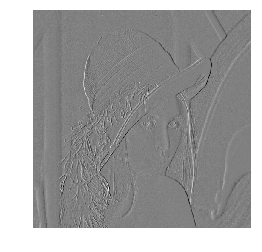

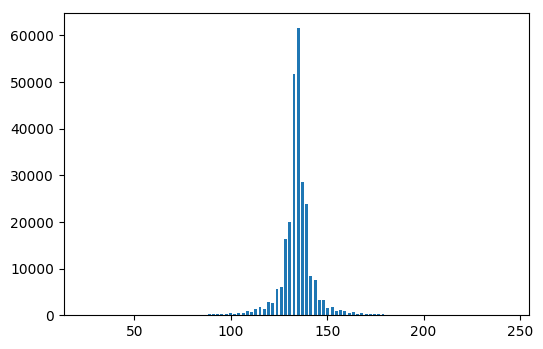

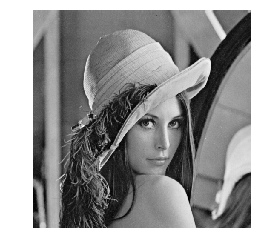

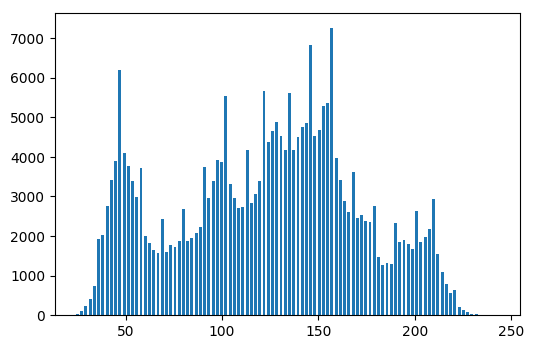

In [6]:
# Test the difference transforms

diff_im = forward_difference(im)
orig_im = backward_difference(diff_im)

assert np.max(np.abs(im - orig_im)) < 1e-10, 'Should be equal'

orig_hist, bin_edges = np.histogram(im.ravel(), bins=100)
diff_hist, _ = np.histogram(diff_im.ravel(), bins=100)
temp_hist, _ = np.histogram(orig_im.ravel(), bins=100)

fig_num = plot_image(diff_im, fig_num, fname='assets/images/diff_lena.png')
plt.figure(fig_num, dpi=100)
plt.bar(bin_edges[:-1], diff_hist, width=1.5)
plt.savefig('assets/images/diff_lena_hist.png', bbox_inches='tight', transparent=True)

fig_num = plot_image(orig_im, fig_num+1)
plt.figure(fig_num, dpi=100)
plt.bar(bin_edges[:-1], orig_hist, width=1.5)
plt.savefig('assets/images/orig_lena_hist.png', bbox_inches='tight', transparent=True)

## Bit-planes

Here, we describe two different methods of slicing bit planes of a value.


Legend:
- $n$: bit position, for a value of 8 bits, n takes values from 7 (most significant) 
  to 0 (least significant). The reverse order is because we want the most significant
  bit plane slice first.
- $v$: pixel value, integer in [0, 255].
    
### Method 1:

Check if the result $r_1$ of an integer division between $v$ and a power of 2,

$$
r_1 = v // 2^n
$$

is odd. If the result is odd, the bit at position $n$ has value 1, if result is even,
the bit at position $n$ has value 0.
        
### Method 2:

Use bitwise and (&) to test equality between $v$ and (1 << $n$). The `(a << b)` operation moves the bits of `a`
`b` places to the left, and fills with 0 from the right: (1 << 0) = 1, and (1 << 3) = 1000. Let

$$
r_2 = v \& (1 << n),
$$

now, $r_2$ will be 0 if v has a 0 at bit position $n$, otherwise $r_2 = 2^n$.

    
### Example:

Let $v=234$ in decimal (11101010 in binary).


$n$ | $r_1$ | bit value (Method 1) | $r_2$ | bit value (Method 2) |
---:|------:|---------------------:|------:|---------------------:|
7   |     1 |                    1 |   128 |                    1 |
6   |     3 |                    1 |    64 |                    1 |
5   |     7 |                    1 |    32 |                    1 |
4   |    14 |                    0 |     0 |                    0 |
3   |    29 |                    1 |     8 |                    1 |
2   |    58 |                    0 |     0 |                    0 |
1   |   117 |                    1 |     2 |                    1 |
0   |   234 |                    0 |     0 |                    0 |


In [7]:
def bit_planes(im):
    """Return a list of 8 bit planes of the input uint8 image."""
    bit_planes = []
    for n in range(7, -1, -1):
        bit_planes.append(np.mod(im // (2**n), 2))
    return bit_planes

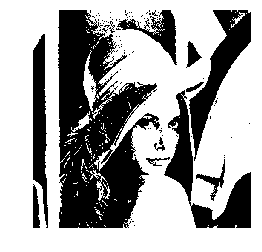

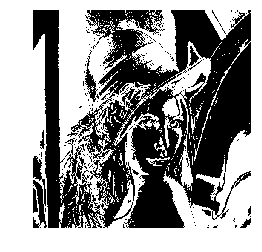

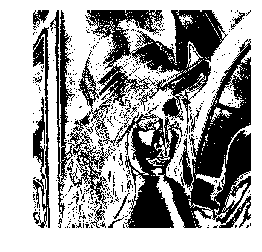

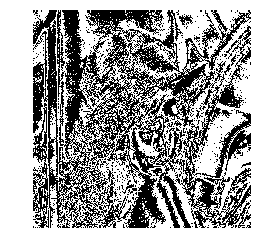

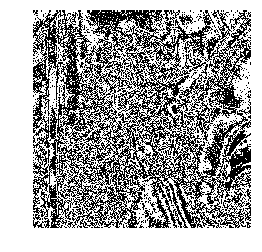

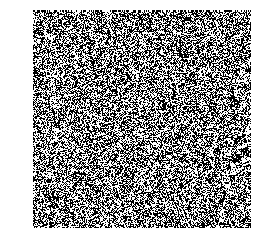

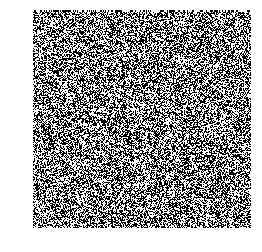

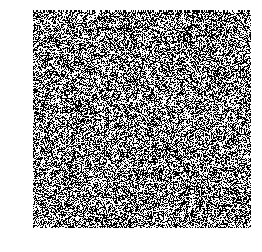

In [14]:
fig_num = 0
for n, plane in enumerate(bit_planes(im)):
    fig_num = plot_image(255*plane, fig_num, 'assets/images/lena_bitplane_{}.png'.format(7-n))

## Gray code

In [23]:
def nat2gray(nat_list):
    """Convert a binary from a natural coding to gray coding"""
    
    gray_list = []
    
    complement = False
    for nat_val in nat_list:
        # Traverse from msb to lsb
        if complement:
            gray_list.append(1 - nat_val)
        else:
            gray_list.append(nat_val)
        if nat_val == 1:
            complement = True
        else: # if nat_val == 0:
            complement = False
            
    return gray_list

In [26]:
def gray2nat(gray_list):
    """Convert a binary from a gray coding to a natural coding"""
    
    nat_list = []
    
    complement = False
    for gray_val in gray_list:
        # Traverse from msb to lsb
        if complement:
            nat_list.append(1 - gray_val)
        else:
            nat_list.append(gray_val)
        if gray_val == 1:
            complement = (not complement)
    return nat_list

In [27]:
def decimal2bin(decimal, num_bits):
    """Convert the input decimal value to a gray coded binary list
    
    Args:
        decimal: scalar value.
        num_bits: scalar value. Greater than or equal to the number of bits in decimal.
        
    Returns:
        bin_array: List of length num_bits. The natural binary code representation of decimal.
        gray_array: List of length num_bits. The Gray code representation of decimal.
    """
    
    bin_string = "{0:b}".format(decimal)
    bin_list = [0 for _ in range(num_bits - len(bin_string))] + [int(bit_val) for bit_val in bin_string]
    gray_list = nat2gray(bin_list)
    return bin_list, gray_list

Test the correctness of the implementation

In [32]:
for val in range(16):
    nat_val, gray_val = decimal2bin(val, 4)
    assert nat_val == gray2nat(gray_val), 'Should be equal'
    print(val, gray_val, nat_val)

0 [0, 0, 0, 0] [0, 0, 0, 0]
1 [0, 0, 0, 1] [0, 0, 0, 1]
2 [0, 0, 1, 1] [0, 0, 1, 0]
3 [0, 0, 1, 0] [0, 0, 1, 1]
4 [0, 1, 1, 0] [0, 1, 0, 0]
5 [0, 1, 1, 1] [0, 1, 0, 1]
6 [0, 1, 0, 1] [0, 1, 1, 0]
7 [0, 1, 0, 0] [0, 1, 1, 1]
8 [1, 1, 0, 0] [1, 0, 0, 0]
9 [1, 1, 0, 1] [1, 0, 0, 1]
10 [1, 1, 1, 1] [1, 0, 1, 0]
11 [1, 1, 1, 0] [1, 0, 1, 1]
12 [1, 0, 1, 0] [1, 1, 0, 0]
13 [1, 0, 1, 1] [1, 1, 0, 1]
14 [1, 0, 0, 1] [1, 1, 1, 0]
15 [1, 0, 0, 0] [1, 1, 1, 1]


Print out Gray coded bit planes of an image (a bit naive parhaps).

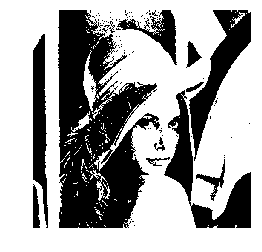

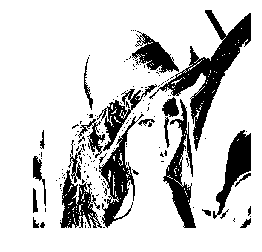

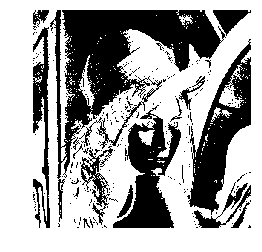

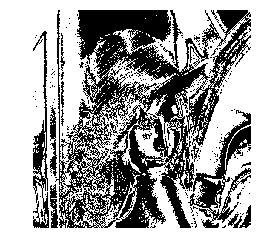

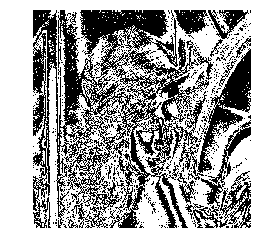

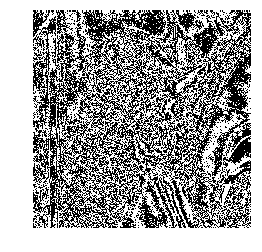

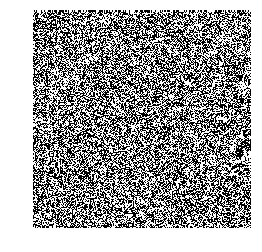

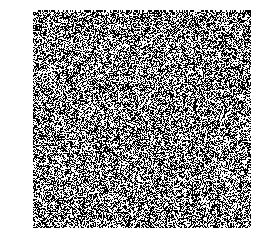

In [15]:
gray_planes = np.zeros((im.shape[0], im.shape[1], 8)) # Assume 8-bit image
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        _, gray_vals = decimal2bin(im[i, j], 8)
        gray_planes[i, j, :] = gray_vals

fig_num = 0
for n in range(8):
    #fig_num = plot_image(255*plane, fig_num, 'assets/images/lena_bitplane_{}.png'.format(7-n))
    fig_num = plot_image(255*gray_planes[:, :, n], fig_num, 'assets/images/lena_grayplane_{}.png'.format(7-n))